# June, 24th, 2021

**Motivation**: There are two motivations:<br>
1) **Reproducibility** initial analysis: how similar/different are these communities similar for all 3 sessions? <br>
2) Also, now have ability to load all the data (Mice object iterates over all animals, sessions, and runs) <br>

In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from myterial import orange, blue_grey
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')

# GitHub
sys.path.insert(0, pjoin(git_dir, 'Ca-fMRI'))
from register.register import *
from analysis.cluster import Clusters
from analysis.hierarchical import *
from analysis.network import *
from utils.plotting import *
from utils.render import *
from model.mouse import Mice
from model.configuration import Config

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
# HIDE CODE


def plot_parcellation(
    parcellation: np.ndarray,
    mask_l: np.ndarray,
    mask_r: np.ndarray,
    root_mask: np.ndarray,
    figsize=(6, 4),
    cmap='turbo', ):

    sns.set_style('whitegrid')
    fig, axes = plt.subplots(2, 3, figsize=figsize)
    for i in range(2):
        for j in range(3):
            x = parcellation.copy()

            if i == 0:
                x[mask_r] = 0
                label = 'left\n'
            else:
                x[mask_l] = 0
                # x[x != 0] -= int(np.max(parcellation) // 2)
                label = 'right\n'

            if j == 0:
                title = 'coronal'
            elif j == 1:
                title = 'axial'
            else:
                title = 'saggital'

            data2plt = np.ma.masked_where(~root_mask.astype(bool), x)
            axes[i, j].imshow(data2plt.mean(j), cmap=cmap)

            list(map(lambda x: x.set_visible(False), axes[i, j].spines.values()))
            axes[i, j].set_xticks([])
            axes[i, j].set_yticks([])

            if i == 0:
                axes[i, j].set_title(title, fontsize=17, y=1.2)
            else:
                axes[i, j].set_title('')
            if j == 0:
                axes[i, j].set_ylabel(label, fontsize=17)

    fig.tight_layout()
    plt.show()
    
    return fig, axes


def viz_parcel(parcellation, figsize=(10, 4), bins=80):
    accepted, rejected = [], []
    all_distances_accepted = []
    for i, ctr in parcellation['cluster_centers'].items():
        num_voxels = (parcellation['parcel'] == i).sum()
        num_accepted = (parcellation['eroded'] == i).sum()    

        accepted.append(num_accepted) 
        rejected.append(num_voxels - num_accepted)

        points = np.array(tuple(zip(*np.where(parcellation['eroded'] == i))))
        d = sp_dist.cdist(ctr.reshape(-1, 3), points.reshape(-1, 3)).flatten()
        all_distances_accepted.extend(list(d))


    fig, axes = create_figure(1, 2, figsize, style='whitegrid')

    sns.histplot(rejected, color='C7', label='rejected', alpha=0.3, ax=axes[0])
    sns.histplot(accepted, color='C2', label='accepted', alpha=0.7, ax=axes[0])
    _min = np.min(accepted)
    _median = np.median(accepted)
    _max = np.max(accepted)
    axes[0].axvline(_min, color='C4', ls='--', lw=1.3, label=f"min: {_min}")
    axes[0].axvline(_median, color='C3', ls='--', lw=1.5, label=f"median: {_median}")
    axes[0].axvline(_max, color='C4', ls='--', lw=1.3, label=f"max: {_max}")
    axes[0].set_title('distribution of ROI sizes', fontsize=15, y=1.03)
    axes[0].set_xlabel('num voxels', fontsize=14)
    axes[0].legend()

    y, bin_edges = np.histogram(all_distances_accepted, bins=bins)
    x = (bin_edges[1:] + bin_edges[:-1]) / 2
    m, b = np.polyfit(x[y > 0], np.log2(y[y > 0]), 1)
    
    sns.histplot(
        all_distances_accepted, color='C6', stat='count',
        kde=True, line_kws={'lw': 4, 'label': f"fitted slope (log2): {np.round(m, 2)}"}, ax=axes[1]
    )
    axes[1].axvline(
        parcellation['radius'], color='k',
        label=f"max radius: {np.round(parcellation['radius'], 2)}",
        ls='--', lw=2
    )
    axes[1].set_xscale('log', base=2)
    axes[1].set_yscale('log', base=2)
    axes[1].set_title('voxel distances from ROI ctrs (eroded)', fontsize=15, y=1.03)
    axes[1].set_xlabel('r', fontsize=14)
    axes[1].legend(fontsize=13)

    fig.tight_layout()
    plt.show()

## Allen & Atlas

In [3]:
mice = Mice(Config(128))
allen = load_allen()
atlas = load_bg_atlas()
atlas.space

...merging dicts: 0it [00:00, ?it/s]

allen mouse atlas (res. 100um)
From: http://www.brain-map.org (Wang et al 2020, https://doi.org/10.1016/j.cell.2020.04.007 )


<BGSpace AnatomicalSpace object>
origin: ('Anterior', 'Superior', 'Left')
sections: ('Frontal plane', 'Horizontal plane', 'Sagittal plane')
shape: (132, 80, 114)

In [4]:
parcellation = kmeans_parcellation(
    mask=allen['isocortex_mask'],
    n_hemisphere_regions=mice.cfg.n_cortex_regions // 2,
    symmetrize=False,
    left_right_axis=2,
    random_state=mice.cfg.random_state,
)

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


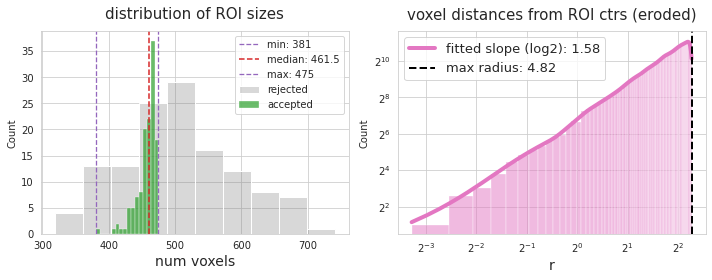

In [5]:
viz_parcel(parcellation)

In [6]:
roi_masks, major_masks = get_roi_masks(parcellation, allen)

allen mouse atlas (res. 100um)
From: http://www.brain-map.org (Wang et al 2020, https://doi.org/10.1016/j.cell.2020.04.007 )


In [7]:
pprint(list(major_masks.keys()))

['STR',
 'PAL',
 'OLF',
 'CTXsp',
 'HPF',
 'VIS',
 'TEa',
 'PERI',
 'ECT',
 'RSP',
 'AUD',
 'PTLp',
 'VISC',
 'SS',
 'SSp',
 'SSp-bfd',
 'SSp-ll',
 'SSp-m',
 'SSp-n',
 'SSp-tr',
 'SSp-ul',
 'SSp-un',
 'SSs',
 'GU',
 'ACA',
 'AI',
 'MO',
 'MOp',
 'MOs',
 'ILA',
 'PL',
 'ORB',
 'FRP']


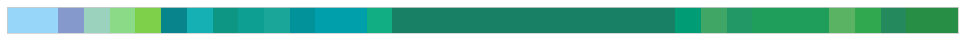

In [8]:
struct_colors = {
    acro: rgb2hex([
        item / 255 for item in
        allen['structure_tree'].get_structures_by_acronym([acro])[0]['rgb_triplet']
    ]) for acro in major_masks
}
struct_cmap = make_cmap(
    ramp_colors=list(struct_colors.values()),
    n_colors=len(struct_colors),
    name='structs',
)

## Summary / Hierarchy

In [9]:
_ = get_subtree(atlas.hierarchy, 315, 2)

Isocortex (315)
├── ACA (31)
├── AI (95)
├── AUD (247)
├── ECT (895)
├── FRP (184)
├── GU (1057)
├── ILA (44)
├── MO (500)
├── ORB (714)
├── PERI (922)
├── PL (972)
├── PTLp (22)
├── RSP (254)
├── SS (453)
├── TEa (541)
├── VIS (669)
└── VISC (677)



In [10]:
table, path = get_summary_table(allen, atlas.hierarchy, export_path=extras_dir)
print(table)

[PROGRESS] 'hierarchy_root-Isocortex.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras

+-----+------+--------------------------------------+-----------+----------+---------------+
| lvl |  id  | name                                 |  acronym  | # voxels | relative size |
+-----+------+--------------------------------------+-----------+----------+---------------+
| --- | ---  | ---                                  |    ---    |   ---    |      ---      |
|  5  | 315  | Isocortex                            | Isocortex |  123245  |     100 %     |
| --- | ---  | ---                                  |    ---    |   ---    |      ---      |
|  6  |  31  | Anterior cingulate area              |    ACA    |   5501   |      4 %      |
|  6  |  95  | Agranular insular area               |     AI    |   7892   |      6 %      |
|  6  | 247  | Auditory areas                       |    AUD    |   5770   |      5 %      |
|  6  | 895  | Ectorhinal area                      |    ECT    |   1728   |      1 %      |
|  6  | 184  | Frontal pole, cerebral cortex        |    FRP    |   966    |      1 %      |
|  6  | 1057 | Gustatory areas                      |     GU    |   1760   |      1 %      |
|  6  |  44  | Infralimbic area                     |    ILA    |   849    |      1 %      |
|  6  | 500  | Somatomotor areas                    |     MO    |  24472   |      20 %     |
|  6  | 714  | Orbital area                         |    ORB    |   5886   |      5 %      |
|  6  | 922  | Perirhinal area                      |    PERI   |   797    |      1 %      |
|  6  | 972  | Prelimbic area                       |     PL    |   2433   |      2 %      |
|  6  |  22  | Posterior parietal association areas |    PTLp   |   2454   |      2 %      |
|  6  | 254  | Retrosplenial area                   |    RSP    |  10455   |      8 %      |
|  6  | 453  | Somatosensory areas                  |     SS    |  33317   |      27 %     |
|  6  | 541  | Temporal association areas           |    TEa    |   3106   |      3 %      |
|  6  | 669  | Visual areas                         |    VIS    |  13489   |      11 %     |
|  6  | 677  | Visceral area                        |    VISC   |   2370   |      2 %      |
| --- | ---  | ---                                  |    ---    |   ---    |      ---      |
|  7  | 985  | Primary motor area                   |    MOp    |  11376   |      9 %      |
|  7  | 993  | Secondary motor area                 |    MOs    |  13096   |      11 %     |
| --- | ---  | ---                                  |    ---    |   ---    |      ---      |
|  7  | 322  | Primary somatosensory area           |    SSp    |  24324   |      20 %     |
|  7  | 378  | Supplemental somatosensory area      |    SSs    |   8993   |      7 %      |
| --- | ---  | ---                                  |    ---    |   ---    |      ---      |
|  8  | 329  | SSp, barrel field                    |  SSp-bfd  |   6281   |      5 %      |
|  8  | 337  | SSp, lower limb                      |   SSp-ll  |   2361   |      2 %      |
|  8  | 345  | SSp, mouth                           |   SSp-m   |   6224   |      5 %      |
|  8  | 353  | SSp, nose                            |   SSp-n   |   3032   |      2 %      |
|  8  | 361  | SSp, trunk                           |   SSp-tr  |   1399   |      1 %      |
|  8  | 369  | SSp, upper limb                      |   SSp-ul  |   3764   |      3 %      |
|  8  |      | SSp, unassigned                      |   SSp-un  |   1263   |      1 %      |
| --- | ---  | ---                                  |    ---    |   ---    |      ---      |
+-----+------+--------------------------------------+-----------+----------+---------------+

In [11]:
file = f"../../_extras/hierarchy_root-{allen['isocortex']['name']}.html"
display(HTML(file))

lvl,id,name,acronym,# voxels,relative size
---,---,---,---,---,---
5,315,Isocortex,Isocortex,123245,100 %
---,---,---,---,---,---
6,31,Anterior cingulate area,ACA,5501,4 %
6,95,Agranular insular area,AI,7892,6 %
6,247,Auditory areas,AUD,5770,5 %
6,895,Ectorhinal area,ECT,1728,1 %
6,184,"Frontal pole, cerebral cortex",FRP,966,1 %
6,1057,Gustatory areas,GU,1760,1 %
6,44,Infralimbic area,ILA,849,1 %


## Combine all data

In [12]:
selected_experiments = [v for k, v in mice.bold_df_piv.items() if mice.bold[k].task == 'rest']
df_combined = pd.concat(selected_experiments)
node_labels = df_combined.columns.values.tolist()
node_labels = {i: lbl for i, lbl in enumerate(node_labels)}

df_combined.shape, len(node_labels), len(mice.bold_df_piv), len(selected_experiments)

((62700, 138), 138, 204, 114)

In [13]:
df_combined

region_id,0-1089,0-315-1,0-315-10,0-315-11,0-315-12,0-315-13,0-315-14,0-315-15,0-315-16,0-315-17,...,1-315-94,1-315-95,1-315-96,1-315-97,1-315-98,1-315-99,1-477,1-698,1-703,1-803
timepoint,,,,,,,,,,,,,,,,,,,,,
50,0.177307,0.239668,1.540850,-0.120437,0.833769,-0.954716,1.073582,0.063512,0.164401,0.183663,...,0.130772,-1.255089,0.333813,0.582112,-0.543934,0.191352,0.075820,-0.056418,0.249776,-0.106711
51,0.121334,-0.351308,1.236763,-0.387884,0.436829,-1.099413,0.507767,-0.523503,-0.465110,0.549863,...,0.499272,-0.690861,0.344502,0.818905,-0.204374,-0.463297,0.095729,-0.082629,0.406547,0.021615
52,-0.216704,-0.443732,0.404563,0.009616,-0.149874,-0.389781,-0.198654,-0.890743,-0.941087,-0.015157,...,0.213801,0.362015,0.812766,1.023933,0.476890,-0.435252,0.231784,0.006075,0.338115,0.242623
53,-0.300723,0.168296,0.042368,0.576017,-0.370759,-0.424792,-0.688525,-0.381481,-1.049068,-0.539598,...,-0.156680,1.074076,0.867756,0.638344,0.706912,-0.103269,0.339838,0.041035,0.341165,0.385404
54,-0.199669,0.881770,0.045310,0.368568,-0.429991,-1.019218,-1.372705,0.253748,-0.968735,-0.421924,...,-0.177024,0.612549,0.363863,-0.364822,0.054722,-0.345933,0.391613,0.018773,0.236386,0.614650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4195,0.040063,-0.215646,-0.989807,0.411229,0.470033,-0.018310,0.349514,0.933415,1.292025,-0.375204,...,-0.657009,0.111733,-0.589974,-0.138369,-0.168534,0.045931,0.045460,0.020959,0.293436,0.194937
4196,-0.152087,0.587896,-0.506389,0.051919,0.825094,0.230065,0.394845,0.448798,1.574733,-1.293223,...,-0.612136,0.989931,-1.001354,0.086990,0.304888,0.312964,-0.144804,0.104323,-0.063012,-0.054406
4197,-0.188290,1.295589,0.159351,-0.038900,0.922255,-0.451525,-0.014617,-0.529758,1.457971,-1.437715,...,-0.309789,1.094104,-1.036641,0.423759,-0.129428,0.221919,-0.104897,0.116850,-0.125495,-0.310437


### Hierarchical clustering

In [18]:
hier_results = hierarchical_cluster(
    df=df_combined,
    method='ward',
    dist_metric='canberra',
    link_metric='canberra',
)
labels = translate_labels(hier_results['labels'], allen['mcc'])

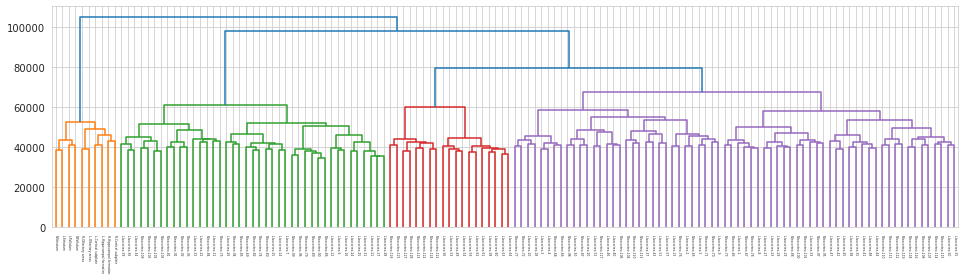

In [19]:
hier_output = get_clust_graph(
    linkage_mat=hier_results['z'],
    labels=labels,
    num_clusters=0,
    leaf_font_size=3,
    orientation='top',
    figsize=(13.5, 4),
)
display(hier_output['fig'])

In [20]:
sns.color_palette('tab20c', n_colors=20)

### All clusters

In [29]:
cluster_color_idxs = {
    2: [17, 0],
    3: [17, 8, 12], 
    4: [17, 8, 12, 14],
    5: [17, 8, 12, 4, 0],
    6: [17, 8, 10, 12, 4, 0],
    7: [17, 8, 10, 12, 14, 4, 0],
    8: [17, 8, 10, 12, 14, 4, 6, 0],
    9: [17, 8, 10, 12, 14, 4, 6, 0, 2],
    10: [17, 8, 10, 12, 14, 4, 6, 7, 0, 2],
    11: [17, 8, 10, 12, 14, 4, 5, 6, 7, 0, 2],
    12: [17, 8, 10, 12, 14, 4, 5, 6, 7, 0, 2, 3],
    13: [16, 17, 8, 10, 12, 14, 4, 5, 6, 7, 0, 2, 3],
    14: [16, 17, 8, 10, 11, 12, 14, 4, 5, 6, 7, 0, 2, 3],
    15: [16, 17, 8, 9, 10, 11, 12, 14, 4, 5, 6, 7, 0, 2, 3],
}
struct_colors = {
    acro: rgb2hex([
        item / 255 for item in
        allen['structure_tree'].get_structures_by_acronym([acro])[0]['rgb_triplet']
    ]) for acro in major_masks
}

n_clusters = 2

#1f77b4,"['(10)', '(128)']"


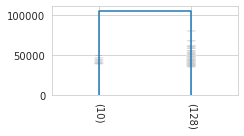

[PROGRESS] 'overlap-regions_n-2.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras

[PROGRESS] 'overlap-clusters_n-2.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras

n_clusters = 3

#1f77b4,"['(10)', '(41)', '(87)']"


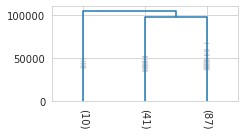

[PROGRESS] 'overlap-regions_n-3.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras

[PROGRESS] 'overlap-clusters_n-3.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras

n_clusters = 4

#1f77b4,"['(10)', '(41)', '(19)', '(68)']"


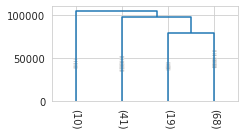

[PROGRESS] 'overlap-regions_n-4.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras

[PROGRESS] 'overlap-clusters_n-4.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras

n_clusters = 5

#1f77b4,"['(10)', '(41)', '(19)']"
#ff7f0e,"['(32)', '(36)']"


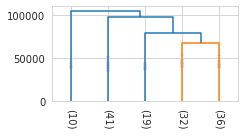

[PROGRESS] 'overlap-regions_n-5.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras

[PROGRESS] 'overlap-clusters_n-5.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras

n_clusters = 6

#1f77b4,"['(10)', '(19)']"
#ff7f0e,"['(16)', '(25)']"
#2ca02c,"['(32)', '(36)']"


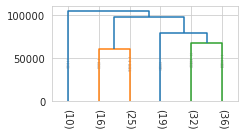

[PROGRESS] 'overlap-regions_n-6.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras

[PROGRESS] 'overlap-clusters_n-6.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras

n_clusters = 7

#1f77b4,['(10)']
#ff7f0e,"['(16)', '(25)']"
#2ca02c,"['(8)', '(11)']"
#d62728,"['(32)', '(36)']"


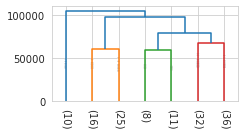

[PROGRESS] 'overlap-regions_n-7.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras

[PROGRESS] 'overlap-clusters_n-7.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras

n_clusters = 8

#1f77b4,['(10)']
#ff7f0e,"['(16)', '(25)']"
#2ca02c,"['(8)', '(11)']"
#d62728,"['(8)', '(24)', '(36)']"


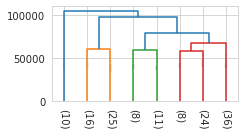

[PROGRESS] 'overlap-regions_n-8.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras

[PROGRESS] 'overlap-clusters_n-8.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras

n_clusters = 9

#1f77b4,['(10)']
#ff7f0e,"['(16)', '(25)']"
#2ca02c,"['(8)', '(11)']"
#d62728,"['(20)', '(8)', '(24)', '(16)']"


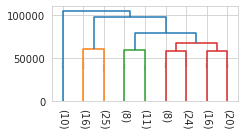

[PROGRESS] 'overlap-regions_n-9.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras

[PROGRESS] 'overlap-clusters_n-9.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras

n_clusters = 10

#1f77b4,['(10)']
#ff7f0e,"['(16)', '(25)']"
#2ca02c,"['(8)', '(11)']"
#d62728,"['(8)', '(9)', '(15)', '(16)', '(20)']"


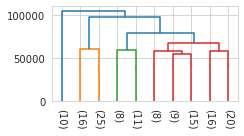

[PROGRESS] 'overlap-regions_n-10.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras

[PROGRESS] 'overlap-clusters_n-10.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras

n_clusters = 11

#1f77b4,['(10)']
#ff7f0e,"['(16)', '(25)']"
#2ca02c,"['(8)', '(11)']"
#d62728,"['(8)', '(9)', '(7)', '(8)', '(16)', '(20)']"


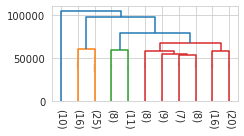

[PROGRESS] 'overlap-regions_n-11.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras

[PROGRESS] 'overlap-clusters_n-11.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras

n_clusters = 12

#1f77b4,['(10)']
#ff7f0e,"['(16)', '(25)']"
#2ca02c,"['(8)', '(11)']"
#d62728,"['(8)', '(9)', '(7)', '(8)', '(16)', '(8)', '(12)']"


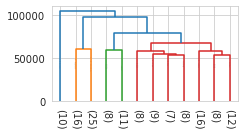

[PROGRESS] 'overlap-regions_n-12.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras

[PROGRESS] 'overlap-clusters_n-12.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras

n_clusters = 13

#ff7f0e,"['(4)', '(6)']"
#2ca02c,"['(16)', '(25)']"
#d62728,"['(8)', '(11)']"
#9467bd,"['(8)', '(9)', '(7)', '(8)', '(16)', '(8)', '(12)']"


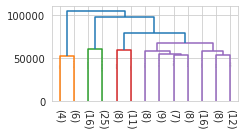

[PROGRESS] 'overlap-regions_n-13.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras

[PROGRESS] 'overlap-clusters_n-13.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras

n_clusters = 14

#ff7f0e,"['(4)', '(6)']"
#2ca02c,"['(16)', '(10)', '(15)']"
#d62728,"['(8)', '(11)']"
#9467bd,"['(8)', '(9)', '(7)', '(8)', '(16)', '(8)', '(12)']"


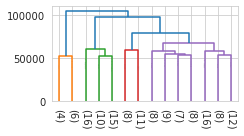

[PROGRESS] 'overlap-regions_n-14.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras

[PROGRESS] 'overlap-clusters_n-14.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras

n_clusters = 15

#ff7f0e,"['(4)', '(6)']"
#2ca02c,"['(7)', '(9)', '(10)', '(15)']"
#d62728,"['(8)', '(11)']"
#9467bd,"['(8)', '(9)', '(7)', '(8)', '(16)', '(8)', '(12)']"


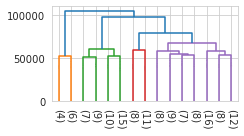

[PROGRESS] 'overlap-regions_n-15.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras

[PROGRESS] 'overlap-clusters_n-15.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras

In [30]:
clusters_all = {}

for n_clusters in range(2, 16):
    hier_output = get_clust_graph(
        linkage_mat=hier_results['z'],
        c_list=cluster_color_idxs[n_clusters],
        labels=labels,
        num_clusters=n_clusters,
        leaf_font_size=10,
        figsize=(3.5, 2),
    )
    print(f"n_clusters = {n_clusters}")
    display(hier_output['cluster_classes'])
    display(hier_output['fig'])
    display(sns.color_palette(hier_output['cluster_colors'].values()))
    print('\n\n')
    
    community = {
        i: translate_labels(leaves, allen['mcc'], forward=False)
        for i, leaves in hier_output['cluster_assigns'].items()
    }
    assert len(community) == n_clusters

    comms3d = np.zeros(allen['template'].shape)
    for cluster_idx, leaves in community.items():
        for lbl in leaves:
            if str(allen['isocortex']['id']) in lbl:
                lr, structure_id, region_id = tuple(map(lambda x: int(x), lbl.split('-')))
                comms3d[parcellation['parcel'] == region_id] = cluster_idx
            else:
                comms3d[roi_masks[lbl]] = cluster_idx
    comms3d = comms3d.astype(int)
    
    # save results
    cluster = Clusters(
        x=comms3d,
        masks=major_masks,
        c_cluster=hier_output['cluster_colors'],
        c_structure=struct_colors,
        threshold=0.0,
    )
    clusters_all[n_clusters] = cluster
    _ = cluster.export(extras_dir)

## Render

In [31]:
for n_clusters in range(2, 16): 
    _ = cluster2html(
        cluster=clusters_all[n_clusters],
        save_name='canberra',
        n_cortex_regions=parcellation['n_cortical_regions'],
        save_dir=extras_dir,
    )

Scene saved at 
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/cluster3d-canberra_parcel-128_n-2.html

Scene saved at 
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/cluster3d-canberra_parcel-128_n-3.html

Scene saved at 
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/cluster3d-canberra_parcel-128_n-4.html

Scene saved at 
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/cluster3d-canberra_parcel-128_n-5.html

Scene saved at 
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/cluster3d-canberra_parcel-128_n-6.html

Scene saved at 
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/cluster3d-canberra_parcel-128_n-7.html

Scene saved at 
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/cluster3d-canberra_parcel-128_n-8.html

Scene saved at 
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/cluster3d-canberra_parcel-128_n-9.html

Scene saved at 
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/cluster3d-canberra_parcel-128_n-10.html

Scene saved at 
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/cluster3d-canberra_parcel-128_n-11.html

Scene saved at 
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/cluster3d-canberra_parcel-128_n-12.html

Scene saved at 
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/cluster3d-canberra_parcel-128_n-13.html

Scene saved at 
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/cluster3d-canberra_parcel-128_n-14.html

Scene saved at 
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/cluster3d-canberra_parcel-128_n-15.html

## Session 1 only

In [40]:
for ses in mice.cfg.ses_ids:
    if ses != 1:
        continue
    
    selected_experiments = {
        k: v for k, v in mice.bold_df_piv.items()
        if mice.bold[k].task == 'rest' and mice.looper[k][1] == ses
    }
    df_combined = pd.concat(list(selected_experiments.values()))
    node_labels = df_combined.columns.values.tolist()
    node_labels = {i: lbl for i, lbl in enumerate(node_labels)}

df_combined.shape, len(node_labels), len(mice.bold_df_piv), len(selected_experiments)

((19800, 138), 138, 204, 36)

In [41]:
list(selected_experiments.keys())

[
    'sub-SLC01_ses-1_run-1',
    'sub-SLC01_ses-1_run-3',
    'sub-SLC01_ses-1_run-5',
    'sub-SLC01_ses-1_run-7',
    'sub-SLC02_ses-1_run-1',
    'sub-SLC02_ses-1_run-3',
    'sub-SLC02_ses-1_run-5',
    'sub-SLC02_ses-1_run-7',
    'sub-SLC03_ses-1_run-2',
    'sub-SLC03_ses-1_run-4',
    'sub-SLC03_ses-1_run-6',
    'sub-SLC04_ses-1_run-1',
    'sub-SLC04_ses-1_run-3',
    'sub-SLC04_ses-1_run-5',
    'sub-SLC04_ses-1_run-7',
    'sub-SLC05_ses-1_run-1',
    'sub-SLC05_ses-1_run-3',
    'sub-SLC05_ses-1_run-7',
    'sub-SLC06_ses-1_run-1',
    'sub-SLC06_ses-1_run-3',
    'sub-SLC06_ses-1_run-5',
    'sub-SLC06_ses-1_run-7',
    'sub-SLC07_ses-1_run-1',
    'sub-SLC07_ses-1_run-3',
    'sub-SLC07_ses-1_run-5',
    'sub-SLC07_ses-1_run-7',
    'sub-SLC08_ses-1_run-3',
    'sub-SLC08_ses-1_run-5',
    'sub-SLC09_ses-1_run-1',
    'sub-SLC09_ses-1_run-3',
    'sub-SLC09_ses-1_run-5',
    'sub-SLC09_ses-1_run-7',
    'sub-SLC10_ses-1_run-1',
    'sub-SLC10_ses-1_run-3',
    'sub-SLC10_ses-1_run-5',
    'sub-SLC10_ses-1_run-7'
]

### Hierarchical clustering

In [44]:
hier_results = hierarchical_cluster(
    df=df_combined,
    method='ward',
    dist_metric='canberra',
    link_metric='canberra',
)
labels = translate_labels(hier_results['labels'], allen['mcc'])

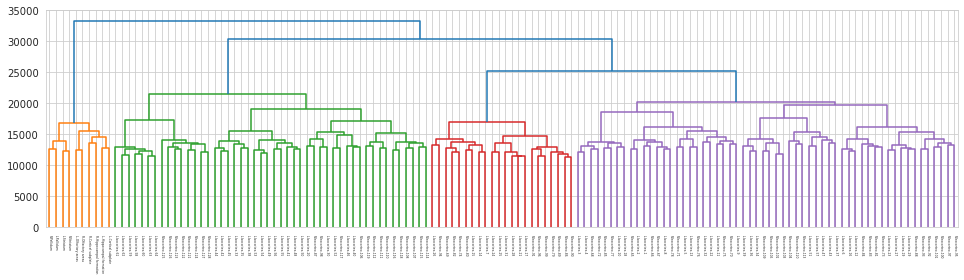

In [45]:
hier_output = get_clust_graph(
    linkage_mat=hier_results['z'],
    labels=labels,
    num_clusters=0,
    leaf_font_size=3,
    orientation='top',
    figsize=(13.5, 4),
)
display(hier_output['fig'])

In [46]:
sns.color_palette('tab20c', n_colors=20)

### All clusters

In [53]:
cluster_color_idxs = {
    2: [17, 0],
    3: [17, 8, 12], 
    4: [17, 8, 12, 14],
    5: [17, 8, 10, 12, 14],
    6: [17, 8, 10, 12, 4, 0],
    7: [17, 8, 10, 12, 4, 0, 2],
    8: [17, 8, 10, 11, 12, 4, 0, 2],
    9: [17, 8, 10, 11, 12, 4, 6, 0, 2],
    10: [17, 8, 10, 11, 12, 4, 6, 0, 2, 3],
    11: [17, 8, 9, 10, 11, 12, 4, 6, 0, 2, 3],
    12: [17, 8, 9, 10, 11, 11, 12, 4, 6, 0, 2, 3],
    13: [17, 8, 9, 10, 11, 11, 12, 14, 4, 6, 0, 2, 3],
    14: [16, 17, 8, 9, 10, 11, 11, 12, 14, 4, 6, 0, 2, 3],
    # 15: [16, 17, 8, 9, 10, 11, 12, 14, 4, 5, 6, 7, 0, 2, 3],
}
struct_colors = {
    acro: rgb2hex([
        item / 255 for item in
        allen['structure_tree'].get_structures_by_acronym([acro])[0]['rgb_triplet']
    ]) for acro in major_masks
}

n_clusters = 2

#1f77b4,"['(10)', '(128)']"


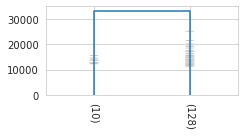

[PROGRESS] 'ses1-regions_n-2.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras

[PROGRESS] 'ses1-clusters_n-2.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras

n_clusters = 3

#1f77b4,"['(10)', '(48)', '(80)']"


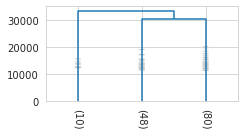

[PROGRESS] 'ses1-regions_n-3.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras

[PROGRESS] 'ses1-clusters_n-3.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras

n_clusters = 4

#1f77b4,"['(10)', '(48)', '(22)', '(58)']"


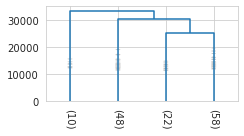

[PROGRESS] 'ses1-regions_n-4.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras

[PROGRESS] 'ses1-clusters_n-4.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras

n_clusters = 5

#1f77b4,"['(10)', '(22)', '(58)']"
#ff7f0e,"['(15)', '(33)']"


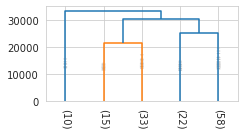

[PROGRESS] 'ses1-regions_n-5.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras

[PROGRESS] 'ses1-clusters_n-5.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras

n_clusters = 6

#1f77b4,"['(10)', '(22)']"
#ff7f0e,"['(15)', '(33)']"
#2ca02c,"['(25)', '(33)']"


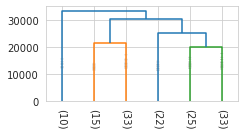

[PROGRESS] 'ses1-regions_n-6.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras

[PROGRESS] 'ses1-clusters_n-6.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras

n_clusters = 7

#1f77b4,"['(10)', '(22)']"
#ff7f0e,"['(15)', '(33)']"
#2ca02c,"['(25)', '(15)', '(18)']"


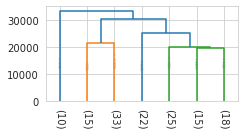

[PROGRESS] 'ses1-regions_n-7.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras

[PROGRESS] 'ses1-clusters_n-7.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras

n_clusters = 8

#1f77b4,"['(10)', '(22)']"
#ff7f0e,"['(15)', '(14)', '(19)']"
#2ca02c,"['(25)', '(15)', '(18)']"


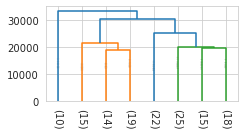

[PROGRESS] 'ses1-regions_n-8.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras

[PROGRESS] 'ses1-clusters_n-8.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras

n_clusters = 9

#1f77b4,"['(10)', '(22)']"
#ff7f0e,"['(15)', '(14)', '(19)']"
#2ca02c,"['(18)', '(8)', '(17)', '(15)']"


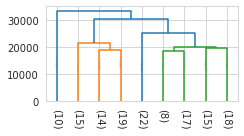

[PROGRESS] 'ses1-regions_n-9.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras

[PROGRESS] 'ses1-clusters_n-9.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras

n_clusters = 10

#1f77b4,"['(10)', '(22)']"
#ff7f0e,"['(15)', '(14)', '(19)']"
#2ca02c,"['(8)', '(17)', '(7)', '(8)', '(18)']"


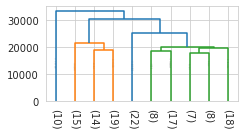

[PROGRESS] 'ses1-regions_n-10.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras

[PROGRESS] 'ses1-clusters_n-10.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras

n_clusters = 11

#1f77b4,"['(10)', '(22)']"
#ff7f0e,"['(7)', '(8)', '(14)', '(19)']"
#2ca02c,"['(8)', '(17)', '(7)', '(8)', '(18)']"


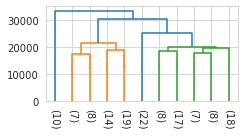

[PROGRESS] 'ses1-regions_n-11.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras

[PROGRESS] 'ses1-clusters_n-11.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras

n_clusters = 12

#1f77b4,"['(10)', '(22)']"
#ff7f0e,"['(7)', '(8)', '(14)', '(9)', '(10)']"
#2ca02c,"['(8)', '(17)', '(7)', '(8)', '(18)']"


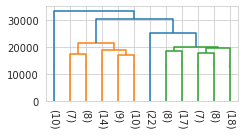

[PROGRESS] 'ses1-regions_n-12.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras

[PROGRESS] 'ses1-clusters_n-12.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras

n_clusters = 13

#1f77b4,['(10)']
#ff7f0e,"['(7)', '(8)', '(14)', '(9)', '(10)']"
#2ca02c,"['(9)', '(13)']"
#d62728,"['(8)', '(17)', '(7)', '(8)', '(18)']"


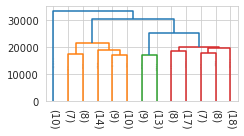

[PROGRESS] 'ses1-regions_n-13.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras

[PROGRESS] 'ses1-clusters_n-13.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras

n_clusters = 14

#ff7f0e,"['(4)', '(6)']"
#2ca02c,"['(7)', '(8)', '(14)', '(9)', '(10)']"
#d62728,"['(13)', '(9)']"
#9467bd,"['(8)', '(17)', '(7)', '(8)', '(18)']"


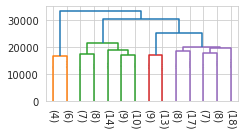

[PROGRESS] 'ses1-regions_n-14.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras

[PROGRESS] 'ses1-clusters_n-14.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras

In [54]:
clusters_all = {}

for n_clusters in range(2, 15):
    hier_output = get_clust_graph(
        linkage_mat=hier_results['z'],
        c_list=cluster_color_idxs[n_clusters],
        labels=labels,
        num_clusters=n_clusters,
        leaf_font_size=10,
        figsize=(3.5, 2),
    )
    print(f"n_clusters = {n_clusters}")
    display(hier_output['cluster_classes'])
    display(hier_output['fig'])
    display(sns.color_palette(hier_output['cluster_colors'].values()))
    print('\n\n')
    
    community = {
        i: translate_labels(leaves, allen['mcc'], forward=False)
        for i, leaves in hier_output['cluster_assigns'].items()
    }
    assert len(community) == n_clusters

    comms3d = np.zeros(allen['template'].shape)
    for cluster_idx, leaves in community.items():
        for lbl in leaves:
            if str(allen['isocortex']['id']) in lbl:
                lr, structure_id, region_id = tuple(map(lambda x: int(x), lbl.split('-')))
                comms3d[parcellation['parcel'] == region_id] = cluster_idx
            else:
                comms3d[roi_masks[lbl]] = cluster_idx
    comms3d = comms3d.astype(int)
    
    # save results
    cluster = Clusters(
        x=comms3d,
        masks=major_masks,
        c_cluster=hier_output['cluster_colors'],
        c_structure=struct_colors,
        threshold=0.0,
    )
    clusters_all[n_clusters] = cluster
    _ = cluster.export(extras_dir, name='ses1')

### Render

In [55]:
for n_clusters in range(2, 15): 
    _ = cluster2html(
        cluster=clusters_all[n_clusters],
        save_name='ses1',
        n_cortex_regions=parcellation['n_cortical_regions'],
        save_dir=extras_dir,
    )

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/cluster3d-ses1_parcel-128_n-2.html

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/cluster3d-ses1_parcel-128_n-3.html

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/cluster3d-ses1_parcel-128_n-4.html

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/cluster3d-ses1_parcel-128_n-5.html

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/cluster3d-ses1_parcel-128_n-6.html

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/cluster3d-ses1_parcel-128_n-7.html

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/cluster3d-ses1_parcel-128_n-8.html

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/cluster3d-ses1_parcel-128_n-9.html

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/cluster3d-ses1_parcel-128_n-10.html

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/cluster3d-ses1_parcel-128_n-11.html

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/cluster3d-ses1_parcel-128_n-12.html

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/cluster3d-ses1_parcel-128_n-13.html

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/cluster3d-ses1_parcel-128_n-14.html

KeyError: 15

## Session 2 only

In [56]:
for ses in mice.cfg.ses_ids:
    if ses != 2:
        continue
    
    selected_experiments = {
        k: v for k, v in mice.bold_df_piv.items()
        if mice.bold[k].task == 'rest' and mice.looper[k][1] == ses
    }
    df_combined = pd.concat(list(selected_experiments.values()))
    node_labels = df_combined.columns.values.tolist()
    node_labels = {i: lbl for i, lbl in enumerate(node_labels)}

df_combined.shape, len(node_labels), len(mice.bold_df_piv), len(selected_experiments)

((20900, 138), 138, 204, 38)

In [57]:
list(selected_experiments.keys())

[
    'sub-SLC01_ses-2_run-1',
    'sub-SLC01_ses-2_run-3',
    'sub-SLC01_ses-2_run-5',
    'sub-SLC01_ses-2_run-7',
    'sub-SLC02_ses-2_run-1',
    'sub-SLC02_ses-2_run-3',
    'sub-SLC02_ses-2_run-5',
    'sub-SLC03_ses-2_run-1',
    'sub-SLC03_ses-2_run-3',
    'sub-SLC03_ses-2_run-5',
    'sub-SLC03_ses-2_run-7',
    'sub-SLC04_ses-2_run-1',
    'sub-SLC04_ses-2_run-3',
    'sub-SLC04_ses-2_run-5',
    'sub-SLC04_ses-2_run-7',
    'sub-SLC05_ses-2_run-1',
    'sub-SLC05_ses-2_run-3',
    'sub-SLC05_ses-2_run-5',
    'sub-SLC05_ses-2_run-7',
    'sub-SLC06_ses-2_run-1',
    'sub-SLC06_ses-2_run-3',
    'sub-SLC06_ses-2_run-5',
    'sub-SLC06_ses-2_run-7',
    'sub-SLC07_ses-2_run-1',
    'sub-SLC07_ses-2_run-3',
    'sub-SLC07_ses-2_run-5',
    'sub-SLC07_ses-2_run-7',
    'sub-SLC08_ses-2_run-1',
    'sub-SLC08_ses-2_run-3',
    'sub-SLC08_ses-2_run-5',
    'sub-SLC08_ses-2_run-7',
    'sub-SLC09_ses-2_run-1',
    'sub-SLC09_ses-2_run-3',
    'sub-SLC09_ses-2_run-5',
    'sub-SLC09_ses-2_run-7',
    'sub-SLC10_ses-2_run-3',
    'sub-SLC10_ses-2_run-5',
    'sub-SLC10_ses-2_run-7'
]

### Hierarchical clustering

In [58]:
hier_results = hierarchical_cluster(
    df=df_combined,
    method='ward',
    dist_metric='canberra',
    link_metric='canberra',
)
labels = translate_labels(hier_results['labels'], allen['mcc'])

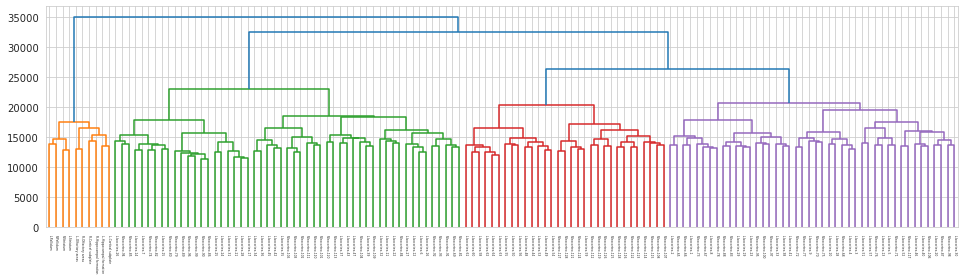

In [59]:
hier_output = get_clust_graph(
    linkage_mat=hier_results['z'],
    labels=labels,
    num_clusters=0,
    leaf_font_size=3,
    orientation='top',
    figsize=(13.5, 4),
)
display(hier_output['fig'])

In [60]:
sns.color_palette('tab20c', n_colors=20)

### All clusters

In [67]:
cluster_color_idxs = {
    2: [17, 0],
    3: [17, 8, 12], 
    4: [17, 8, 12, 14],
    5: [17, 8, 10, 12, 14],
    6: [17, 8, 10, 12, 4, 0],
    7: [17, 8, 10, 12, 14, 4, 0],
    8: [17, 8, 11, 12, 14, 4, 0, 2],
    9: [17, 8, 10, 11, 12, 14, 4, 0, 2],
    10: [17, 8, 9, 10, 11, 12, 14, 4, 0, 2],
    11: [17, 8, 9, 10, 11, 12, 14, 4, 6, 0, 2],
    12: [17, 8, 9, 10, 11, 11, 12, 14, 4, 6, 0, 2],
    13: [17, 8, 9, 10, 11, 11, 12, 14, 4, 6, 0, 2, 3],
    14: [16, 17, 8, 9, 10, 11, 11, 12, 14, 4, 6, 0, 2, 3],
    # 15: [16, 17, 8, 9, 10, 11, 12, 14, 4, 5, 6, 7, 0, 2, 3],
}
struct_colors = {
    acro: rgb2hex([
        item / 255 for item in
        allen['structure_tree'].get_structures_by_acronym([acro])[0]['rgb_triplet']
    ]) for acro in major_masks
}

n_clusters = 2

#1f77b4,"['(10)', '(128)']"


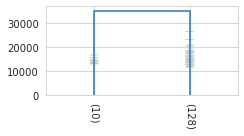

[PROGRESS] 'ses2-regions_n-2.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras

[PROGRESS] 'ses2-clusters_n-2.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras

n_clusters = 3

#1f77b4,"['(10)', '(53)', '(75)']"


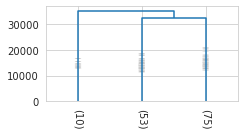

[PROGRESS] 'ses2-regions_n-3.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras

[PROGRESS] 'ses2-clusters_n-3.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras

n_clusters = 4

#1f77b4,"['(10)', '(53)', '(31)', '(44)']"


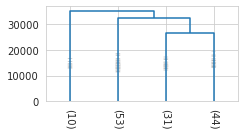

[PROGRESS] 'ses2-regions_n-4.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras

[PROGRESS] 'ses2-clusters_n-4.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras

n_clusters = 5

#1f77b4,"['(10)', '(31)', '(44)']"
#ff7f0e,"['(21)', '(32)']"


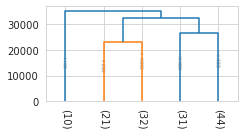

[PROGRESS] 'ses2-regions_n-5.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras

[PROGRESS] 'ses2-clusters_n-5.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras

n_clusters = 6

#1f77b4,"['(10)', '(31)']"
#ff7f0e,"['(21)', '(32)']"
#2ca02c,"['(19)', '(25)']"


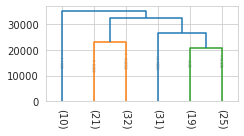

[PROGRESS] 'ses2-regions_n-6.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras

[PROGRESS] 'ses2-clusters_n-6.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras

n_clusters = 7

#1f77b4,['(10)']
#ff7f0e,"['(21)', '(32)']"
#2ca02c,"['(14)', '(17)']"
#d62728,"['(19)', '(25)']"


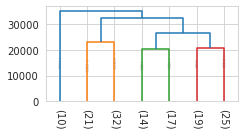

[PROGRESS] 'ses2-regions_n-7.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras

[PROGRESS] 'ses2-clusters_n-7.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras

n_clusters = 8

#1f77b4,['(10)']
#ff7f0e,"['(21)', '(32)']"
#2ca02c,"['(14)', '(17)']"
#d62728,"['(19)', '(10)', '(15)']"


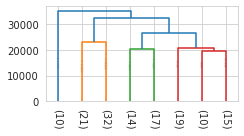

[PROGRESS] 'ses2-regions_n-8.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras

[PROGRESS] 'ses2-clusters_n-8.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras

n_clusters = 9

#1f77b4,['(10)']
#ff7f0e,"['(21)', '(11)', '(21)']"
#2ca02c,"['(14)', '(17)']"
#d62728,"['(15)', '(19)', '(10)']"


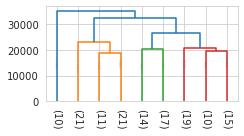

[PROGRESS] 'ses2-regions_n-9.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras

[PROGRESS] 'ses2-clusters_n-9.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras

n_clusters = 10

#1f77b4,['(10)']
#ff7f0e,"['(21)', '(11)', '(8)', '(13)']"
#2ca02c,"['(14)', '(17)']"
#d62728,"['(10)', '(15)', '(19)']"


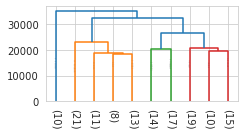

[PROGRESS] 'ses2-regions_n-10.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras

[PROGRESS] 'ses2-clusters_n-10.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras

n_clusters = 11

#1f77b4,['(10)']
#ff7f0e,"['(21)', '(11)', '(8)', '(13)']"
#2ca02c,"['(14)', '(17)']"
#d62728,"['(11)', '(10)', '(15)', '(8)']"


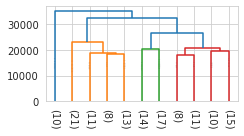

[PROGRESS] 'ses2-regions_n-11.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras

[PROGRESS] 'ses2-clusters_n-11.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras

n_clusters = 12

#1f77b4,['(10)']
#ff7f0e,"['(9)', '(12)', '(11)', '(8)', '(13)']"
#2ca02c,"['(14)', '(17)']"
#d62728,"['(8)', '(11)', '(10)', '(15)']"


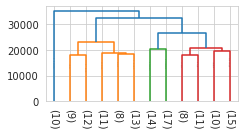

[PROGRESS] 'ses2-regions_n-12.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras

[PROGRESS] 'ses2-clusters_n-12.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras

n_clusters = 13

#1f77b4,['(10)']
#ff7f0e,"['(9)', '(12)', '(11)', '(8)', '(13)']"
#2ca02c,"['(14)', '(17)']"
#d62728,"['(8)', '(11)', '(10)', '(6)', '(9)']"


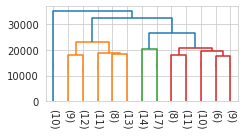

[PROGRESS] 'ses2-regions_n-13.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras

[PROGRESS] 'ses2-clusters_n-13.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras

n_clusters = 14

#ff7f0e,"['(4)', '(6)']"
#2ca02c,"['(9)', '(12)', '(11)', '(8)', '(13)']"
#d62728,"['(17)', '(14)']"
#9467bd,"['(8)', '(11)', '(10)', '(6)', '(9)']"


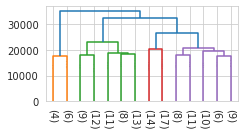

[PROGRESS] 'ses2-regions_n-14.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras

[PROGRESS] 'ses2-clusters_n-14.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras

In [68]:
clusters_all = {}

for n_clusters in range(2, 15):
    hier_output = get_clust_graph(
        linkage_mat=hier_results['z'],
        c_list=cluster_color_idxs[n_clusters],
        labels=labels,
        num_clusters=n_clusters,
        leaf_font_size=10,
        figsize=(3.5, 2),
    )
    print(f"n_clusters = {n_clusters}")
    display(hier_output['cluster_classes'])
    display(hier_output['fig'])
    display(sns.color_palette(hier_output['cluster_colors'].values()))
    print('\n\n')
    
    community = {
        i: translate_labels(leaves, allen['mcc'], forward=False)
        for i, leaves in hier_output['cluster_assigns'].items()
    }
    assert len(community) == n_clusters

    comms3d = np.zeros(allen['template'].shape)
    for cluster_idx, leaves in community.items():
        for lbl in leaves:
            if str(allen['isocortex']['id']) in lbl:
                lr, structure_id, region_id = tuple(map(lambda x: int(x), lbl.split('-')))
                comms3d[parcellation['parcel'] == region_id] = cluster_idx
            else:
                comms3d[roi_masks[lbl]] = cluster_idx
    comms3d = comms3d.astype(int)
    
    # save results
    cluster = Clusters(
        x=comms3d,
        masks=major_masks,
        c_cluster=hier_output['cluster_colors'],
        c_structure=struct_colors,
        threshold=0.0,
    )
    clusters_all[n_clusters] = cluster
    _ = cluster.export(extras_dir, name='ses2')

### Render

In [69]:
for n_clusters in range(2, 15): 
    _ = cluster2html(
        cluster=clusters_all[n_clusters],
        save_name='ses2',
        n_cortex_regions=parcellation['n_cortical_regions'],
        save_dir=extras_dir,
    )

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/cluster3d-ses2_parcel-128_n-2.html

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/cluster3d-ses2_parcel-128_n-3.html

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/cluster3d-ses2_parcel-128_n-4.html

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/cluster3d-ses2_parcel-128_n-5.html

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/cluster3d-ses2_parcel-128_n-6.html

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/cluster3d-ses2_parcel-128_n-7.html

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/cluster3d-ses2_parcel-128_n-8.html

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/cluster3d-ses2_parcel-128_n-9.html

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/cluster3d-ses2_parcel-128_n-10.html

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/cluster3d-ses2_parcel-128_n-11.html

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/cluster3d-ses2_parcel-128_n-12.html

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/cluster3d-ses2_parcel-128_n-13.html

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/cluster3d-ses2_parcel-128_n-14.html

## Session 3 only

In [70]:
for ses in mice.cfg.ses_ids:
    if ses != 3:
        continue
    
    selected_experiments = {
        k: v for k, v in mice.bold_df_piv.items()
        if mice.bold[k].task == 'rest' and mice.looper[k][1] == ses
    }
    df_combined = pd.concat(list(selected_experiments.values()))
    node_labels = df_combined.columns.values.tolist()
    node_labels = {i: lbl for i, lbl in enumerate(node_labels)}

df_combined.shape, len(node_labels), len(mice.bold_df_piv), len(selected_experiments)

((22000, 138), 138, 204, 40)

In [71]:
list(selected_experiments.keys())

[
    'sub-SLC01_ses-3_run-1',
    'sub-SLC01_ses-3_run-3',
    'sub-SLC01_ses-3_run-5',
    'sub-SLC01_ses-3_run-7',
    'sub-SLC02_ses-3_run-1',
    'sub-SLC02_ses-3_run-3',
    'sub-SLC02_ses-3_run-5',
    'sub-SLC02_ses-3_run-7',
    'sub-SLC03_ses-3_run-1',
    'sub-SLC03_ses-3_run-3',
    'sub-SLC03_ses-3_run-5',
    'sub-SLC03_ses-3_run-7',
    'sub-SLC04_ses-3_run-1',
    'sub-SLC04_ses-3_run-3',
    'sub-SLC04_ses-3_run-5',
    'sub-SLC04_ses-3_run-7',
    'sub-SLC05_ses-3_run-1',
    'sub-SLC05_ses-3_run-3',
    'sub-SLC05_ses-3_run-5',
    'sub-SLC05_ses-3_run-7',
    'sub-SLC06_ses-3_run-1',
    'sub-SLC06_ses-3_run-3',
    'sub-SLC06_ses-3_run-5',
    'sub-SLC06_ses-3_run-7',
    'sub-SLC07_ses-3_run-1',
    'sub-SLC07_ses-3_run-3',
    'sub-SLC07_ses-3_run-5',
    'sub-SLC07_ses-3_run-7',
    'sub-SLC08_ses-3_run-1',
    'sub-SLC08_ses-3_run-3',
    'sub-SLC08_ses-3_run-5',
    'sub-SLC08_ses-3_run-7',
    'sub-SLC09_ses-3_run-1',
    'sub-SLC09_ses-3_run-3',
    'sub-SLC09_ses-3_run-5',
    'sub-SLC09_ses-3_run-7',
    'sub-SLC10_ses-3_run-1',
    'sub-SLC10_ses-3_run-3',
    'sub-SLC10_ses-3_run-5',
    'sub-SLC10_ses-3_run-7'
]

### Hierarchical clustering

In [72]:
hier_results = hierarchical_cluster(
    df=df_combined,
    method='ward',
    dist_metric='canberra',
    link_metric='canberra',
)
labels = translate_labels(hier_results['labels'], allen['mcc'])

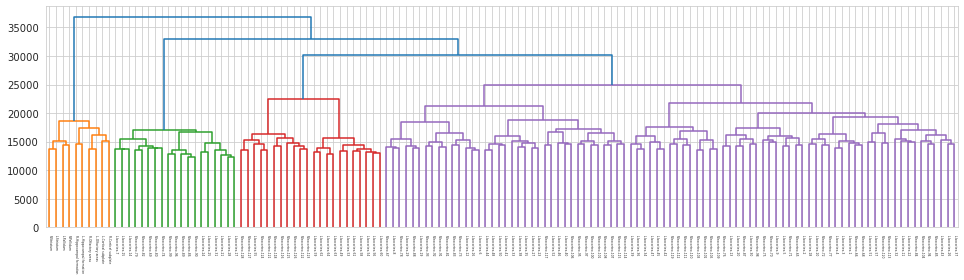

In [73]:
hier_output = get_clust_graph(
    linkage_mat=hier_results['z'],
    labels=labels,
    num_clusters=0,
    leaf_font_size=3,
    orientation='top',
    figsize=(13.5, 4),
)
display(hier_output['fig'])

In [74]:
sns.color_palette('tab20c', n_colors=20)

### All clusters

In [83]:
cluster_color_idxs = {
    2: [17, 0],
    3: [17, 8, 12], 
    4: [17, 8, 12, 14],
    5: [17, 8, 12, 4, 0],
    6: [17, 8, 12, 14, 4, 0],
    7: [17, 8, 12, 14, 4, 0, 2],
    8: [17, 8, 12, 14, 4, 6, 0, 2],
    9: [17, 8, 12, 14, 4, 6, 0, 2, 3],
    10: [17, 8, 12, 14, 4, 6, 0, 1, 2, 3],
    11: [17, 8, 12, 14, 4, 6, 7, 0, 1, 2, 3],
    12: [16, 17, 8, 12, 14, 4, 6, 7, 0, 1, 2, 3],
    13: [16, 17, 8, 12, 14, 4, 5, 6, 7, 0, 1, 2, 3],
    14: [16, 17, 8, 12, 14, 4, 5, 6, 7, 0, 1, 2, 3, 3],
    15: [16, 17, 8, 12, 14, 4, 5, 6, 7, 0, 0, 1, 2, 3, 3],
}
struct_colors = {
    acro: rgb2hex([
        item / 255 for item in
        allen['structure_tree'].get_structures_by_acronym([acro])[0]['rgb_triplet']
    ]) for acro in major_masks
}

n_clusters = 2

#1f77b4,"['(10)', '(128)']"


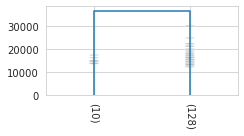

[PROGRESS] 'ses3-regions_n-2.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras

[PROGRESS] 'ses3-clusters_n-2.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras

n_clusters = 3

#1f77b4,"['(10)', '(19)', '(109)']"


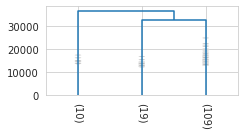

[PROGRESS] 'ses3-regions_n-3.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras

[PROGRESS] 'ses3-clusters_n-3.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras

n_clusters = 4

#1f77b4,"['(10)', '(19)', '(22)', '(87)']"


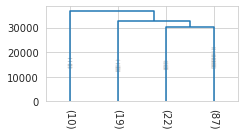

[PROGRESS] 'ses3-regions_n-4.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras

[PROGRESS] 'ses3-clusters_n-4.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras

n_clusters = 5

#1f77b4,"['(10)', '(19)', '(22)']"
#ff7f0e,"['(37)', '(50)']"


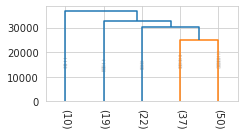

[PROGRESS] 'ses3-regions_n-5.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras

[PROGRESS] 'ses3-clusters_n-5.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras

n_clusters = 6

#1f77b4,"['(10)', '(19)']"
#ff7f0e,"['(11)', '(11)']"
#2ca02c,"['(37)', '(50)']"


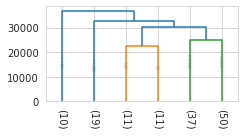

[PROGRESS] 'ses3-regions_n-6.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras

[PROGRESS] 'ses3-clusters_n-6.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras

n_clusters = 7

#1f77b4,"['(10)', '(19)']"
#ff7f0e,"['(11)', '(11)']"
#2ca02c,"['(37)', '(14)', '(36)']"


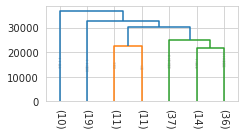

[PROGRESS] 'ses3-regions_n-7.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras

[PROGRESS] 'ses3-clusters_n-7.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras

n_clusters = 8

#1f77b4,"['(10)', '(19)']"
#ff7f0e,"['(11)', '(11)']"
#2ca02c,"['(15)', '(22)', '(14)', '(36)']"


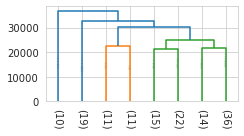

[PROGRESS] 'ses3-regions_n-8.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras

[PROGRESS] 'ses3-clusters_n-8.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras

n_clusters = 9

#1f77b4,"['(10)', '(19)']"
#ff7f0e,"['(11)', '(11)']"
#2ca02c,"['(15)', '(22)', '(14)', '(13)', '(23)']"


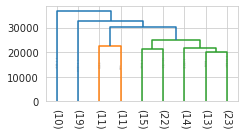

[PROGRESS] 'ses3-regions_n-9.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras

[PROGRESS] 'ses3-clusters_n-9.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras

n_clusters = 10

#1f77b4,"['(10)', '(19)']"
#ff7f0e,"['(11)', '(11)']"
#2ca02c,"['(15)', '(22)', '(14)', '(13)', '(9)', '(14)']"


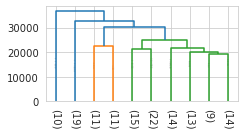

[PROGRESS] 'ses3-regions_n-10.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras

[PROGRESS] 'ses3-clusters_n-10.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras

n_clusters = 11

#1f77b4,"['(10)', '(19)']"
#ff7f0e,"['(11)', '(11)']"
#2ca02c,"['(15)', '(9)', '(13)', '(14)', '(13)', '(9)', '(14)']"


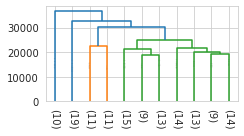

[PROGRESS] 'ses3-regions_n-11.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras

[PROGRESS] 'ses3-clusters_n-11.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras

n_clusters = 12

#1f77b4,['(19)']
#ff7f0e,"['(4)', '(6)']"
#2ca02c,"['(11)', '(11)']"
#d62728,"['(15)', '(9)', '(13)', '(14)', '(13)', '(9)', '(14)']"


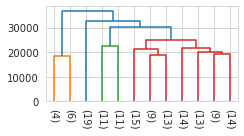

[PROGRESS] 'ses3-regions_n-12.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras

[PROGRESS] 'ses3-clusters_n-12.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras

n_clusters = 13

#1f77b4,['(19)']
#ff7f0e,"['(4)', '(6)']"
#2ca02c,"['(11)', '(11)']"
#d62728,"['(6)', '(9)', '(9)', '(13)', '(14)', '(13)', '(9)', '(14)']"


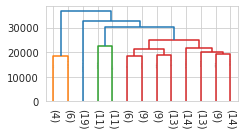

[PROGRESS] 'ses3-regions_n-13.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras

[PROGRESS] 'ses3-clusters_n-13.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras

n_clusters = 14

#1f77b4,['(19)']
#ff7f0e,"['(4)', '(6)']"
#2ca02c,"['(11)', '(11)']"
#d62728,"['(6)', '(9)', '(9)', '(13)', '(14)', '(13)', '(9)', '(4)', '(10)']"


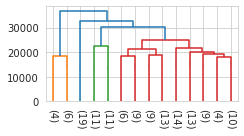

[PROGRESS] 'ses3-regions_n-14.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras

[PROGRESS] 'ses3-clusters_n-14.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras

n_clusters = 15

#1f77b4,['(19)']
#ff7f0e,"['(4)', '(6)']"
#2ca02c,"['(11)', '(11)']"
#d62728,"['(6)', '(9)', '(9)', '(13)', '(6)', '(8)', '(13)', '(9)', '(4)', '(10)']"


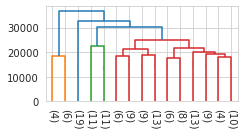

[PROGRESS] 'ses3-regions_n-15.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras

[PROGRESS] 'ses3-clusters_n-15.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras

In [84]:
clusters_all = {}

for n_clusters in range(2, 16):
    hier_output = get_clust_graph(
        linkage_mat=hier_results['z'],
        c_list=cluster_color_idxs[n_clusters],
        labels=labels,
        num_clusters=n_clusters,
        leaf_font_size=10,
        figsize=(3.5, 2),
    )
    print(f"n_clusters = {n_clusters}")
    display(hier_output['cluster_classes'])
    display(hier_output['fig'])
    display(sns.color_palette(hier_output['cluster_colors'].values()))
    print('\n\n')
    
    community = {
        i: translate_labels(leaves, allen['mcc'], forward=False)
        for i, leaves in hier_output['cluster_assigns'].items()
    }
    assert len(community) == n_clusters

    comms3d = np.zeros(allen['template'].shape)
    for cluster_idx, leaves in community.items():
        for lbl in leaves:
            if str(allen['isocortex']['id']) in lbl:
                lr, structure_id, region_id = tuple(map(lambda x: int(x), lbl.split('-')))
                comms3d[parcellation['parcel'] == region_id] = cluster_idx
            else:
                comms3d[roi_masks[lbl]] = cluster_idx
    comms3d = comms3d.astype(int)
    
    # save results
    cluster = Clusters(
        x=comms3d,
        masks=major_masks,
        c_cluster=hier_output['cluster_colors'],
        c_structure=struct_colors,
        threshold=0.0,
    )
    clusters_all[n_clusters] = cluster
    _ = cluster.export(extras_dir, name='ses3')

### Render

In [85]:
for n_clusters in range(2, 16): 
    _ = cluster2html(
        cluster=clusters_all[n_clusters],
        save_name='ses3',
        n_cortex_regions=parcellation['n_cortical_regions'],
        save_dir=extras_dir,
    )

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/cluster3d-ses3_parcel-128_n-2.html

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/cluster3d-ses3_parcel-128_n-3.html

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/cluster3d-ses3_parcel-128_n-4.html

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/cluster3d-ses3_parcel-128_n-5.html

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/cluster3d-ses3_parcel-128_n-6.html

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/cluster3d-ses3_parcel-128_n-7.html

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/cluster3d-ses3_parcel-128_n-8.html

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/cluster3d-ses3_parcel-128_n-9.html

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/cluster3d-ses3_parcel-128_n-10.html

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/cluster3d-ses3_parcel-128_n-11.html

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/cluster3d-ses3_parcel-128_n-12.html

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/cluster3d-ses3_parcel-128_n-13.html

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/cluster3d-ses3_parcel-128_n-14.html

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/cluster3d-ses3_parcel-128_n-15.html

## Which display option below works better?

In [104]:
n_clusters = 5
file = f"../../_extras/overlap-regions_n-{n_clusters}.html"
IFrame(file, width=1000, height=600)

## Embed 3d

In [107]:
n_clusters = 5
file = f"../../_extras/cluster3d-canberra_parcel-{mice.cfg.n_cortex_regions}_n-{n_clusters}.html"
IFrame(file, width=1000, height=700)

## Report properties of a parcellation (TODO)
> use this:
```Python
import pyinspect as pi
```

In [ ]:
    def content(self):
        """
        Prints an overview of the Actors in the scene.
        """

        actors = pi.Report(
            "Scene actors", accent=salmon, dim=orange, color=orange
        )

        for act in self.actors:
            actors.add(
                f"[bold][{amber}]- {act.name}[/bold][{orange_darker}] "
                f"(type: [{orange}]{act.br_class}[/{orange}]) "
                f"(color: [{orange}]{rgb2hex(act.mesh.c())}[/{orange}]) "
                f"(alpha: [{orange}]{act.mesh.alpha()}[/{orange}]) "
            )

        if "win32" != sys.platform:
            actors.print()
        else:
            print(pi.utils.stringify(actors, maxlen=-1))